# The Dymos Solution to the eVTOL Minimum-Energy Takeoff

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenMDAO/RevHack2020//blob/master/problems/evtol_trajectory/evtol_dymos/evtol_dymos.ipynb)

This notebook shows how we used Dymos to minimize the total energy of an electric vertical take-off vehicle.

* The original implementation can be found [here](https://bitbucket.org/shamsheersc19/tilt_wing_evtol_takeoff).
* The problem formulation and results are published [here](https://www.researchgate.net/publication/337259571_Tilt-Wing_eVTOL_Takeoff_Trajectory_Optimization)

The original implementation used 500 steps of an Euler-integration approach, and complex-step differentiation through the Euler-integration (as well as an internal convergence loop).

This implementation seeks to preserve as much of the original approach as possible.
Complex-step is still used for differentiation, but the Euler-integraiton approach is replaced with Dymos.


In [1]:
%%capture
!apt install swig file

In [2]:
%%capture
!wget -c https://raw.githubusercontent.com/OpenMDAO/build_pyoptsparse/master/build_pyoptsparse.sh

In [3]:
%%capture
!bash build_pyoptsparse.sh -p /usr/local

In [4]:
%%capture
!ldconfig

In [5]:
%%capture
!python3 -m pip install git+https://github.com/OpenMDAO/OpenMDAO.git;

In [6]:
%%capture
!python3 -m pip install git+https://github.com/OpenMDAO/dymos.git;

In [7]:
import numpy as np
import openmdao.api as om
import dymos as dm

from openmdao.utils.cs_safe import abs as cs_abs


Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


/usr/local/lib/python3.6/dist-packages/pyoptsparse/pyOpt_MPI.py:63: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


Define a complex-safe arctan2 (this will soon be available in `openmdao.utils.cs_atan2`)

In [8]:
def cs_atan2(y, x):
    """
    A numpy-compatible, complex-compatible arctan2 function for use with complex-step.

    Parameters
    ----------
    y : float or complex
        The length of the side opposite the angle being determined.
    x : float or complex
        The length of the side adjacent to the angle being determined.

    Returns
    -------
    The angle whose opposite side has length y and whose adjacent side has length x.
    """
    a = np.real(y)
    b = np.imag(y)
    c = np.real(x)
    d = np.imag(x)

    if np.any(np.iscomplex(x)) or np.any(np.iscomplex(y)):
        res = np.arctan2(a, c) + 1j * (c * b - a * d) / (a**2 + c**2)
    else:
        res = np.arctan2(a, c)
    return res

The user's interpolation coefficient function for the aerodynamics.

In [9]:
def give_curve_fit_coeffs(a0, AR, e):
    """
    This gives the coefficients for the quartic least-squares curve fit that is used for each wing's
    coefficient of drag below 27.5 deg.

    Parameters
    ----------
    a0 : float
        Airfoil lift-curve slope in 1/rad
    AR : float
        Aspect ratio
    e : float
        Span efficiency factor

    Returns
    -------
    quartic_poly_coeffs : array
        Coefficients of the curve fit
    data_pts : array
        Data points that are fitted
    """

    cla = a0 / (1 + a0 / (np.pi * e * AR))

    data_pts = np.array([[16. / 180. * np.pi, 0.1],  # Tangler--Ostowari points
                         [20. / 180. * np.pi, 0.175],  # Tangler--Ostowari points
                         [25. / 180. * np.pi, 0.275],  # Tangler--Ostowari points
                         [27.5 / 180. * np.pi, 0.363],  # Tangler--Ostowari points
                         [12. / 180. * np.pi,
                          0.015 + (cla * 12. / 180. * np.pi) ** 2 / np.pi / AR / e],
                         [10. / 180. * np.pi,
                          0.012 + (cla * 10. / 180. * np.pi) ** 2 / np.pi / AR / e],
                         [8. / 180. * np.pi,
                          0.0095 + (cla * 8. / 180. * np.pi) ** 2 / np.pi / AR / e],
                         [6. / 180. * np.pi,
                          0.008 + (cla * 6. / 180. * np.pi) ** 2 / np.pi / AR / e],
                         [4. / 180. * np.pi,
                          0.007 + (cla * 4. / 180. * np.pi) ** 2 / np.pi / AR / e],
                         [2. / 180. * np.pi,
                          0.0062 + (cla * 2. / 180. * np.pi) ** 2 / np.pi / AR / e],
                         [0. / 180. * np.pi, 0.006]])

    new_fit_matrix = np.array([[1, data_pts[0, 0] ** 2, data_pts[0, 0] ** 4],
                               [1, data_pts[1, 0] ** 2, data_pts[1, 0] ** 4],
                               [1, data_pts[2, 0] ** 2, data_pts[2, 0] ** 4],
                               [1, data_pts[3, 0] ** 2, data_pts[3, 0] ** 4],
                               [1, data_pts[4, 0] ** 2, data_pts[4, 0] ** 4],
                               [1, data_pts[5, 0] ** 2, data_pts[5, 0] ** 4],
                               [1, data_pts[6, 0] ** 2, data_pts[6, 0] ** 4],
                               [1, data_pts[7, 0] ** 2, data_pts[7, 0] ** 4],
                               [1, data_pts[8, 0] ** 2, data_pts[8, 0] ** 4],
                               [1, data_pts[9, 0] ** 2, data_pts[9, 0] ** 4],
                               [1, data_pts[10, 0] ** 2, data_pts[10, 0] ** 4]])

    quartic_poly_coeffs = np.linalg.solve(np.dot(new_fit_matrix.T, new_fit_matrix),
                                          np.dot(new_fit_matrix.T, data_pts[:, 1]))

    return quartic_poly_coeffs, data_pts

The thrust function.  This contains it's own while-loop-based solver.  Typically we'd use an OpenMDAO solver for this functionality, but since we're complex-stepping through this and everything is complex-safe, this will work (probably with some performance penalty).

In [10]:
def Thrust(u0, power, A, T, rho, kappa):
    """
    This computes the thrust and induced velocity at the propeller disk.
    This uses formulas from propeller momentum theory.

    Parameters
    ----------
    u0 : float
        Freestream speed normal to the propeller disk
    power : float
        Power supplied to the propeller disk
    A : float
        Propeller disk area
    T : float
        Thrust guess
    rho : float
        Air density
    kappa: float
        Correction factor for non-uniform inflow and tip effects

    Returns
    -------
    thrust : float
        Thrust
    v_i : float
        Induced velocity at the propeller disk
    """

    T_old = T + 10.
    thrust = T

    # iteration loop to solve for the thrust as a function of power
    while np.any(np.abs(T_old - thrust) > 1e-10):
        T_old = thrust

        # ### FPI (Fixed point iteration)
        # T_new = power / (u0 + kappa * (-u0/2 + 0.5 * (u0**2 + 2 * thrust / rho / A)**0.5))
        # thrust = thrust + (T_new - thrust) * 0.5

        # # Newton-Raphson
        with np.errstate(all='raise'):
            try:
                root_term = (u0**2 + 2 * thrust / rho / A)**0.5
                R = power - thrust * (u0 + kappa * (-u0 / 2 + 0.5 * root_term))
                R_prime = -u0 - kappa * ( -u0 / 2 + 0.5 * root_term + 0.5 * thrust / rho / A / root_term)
                thrust = T_old - R / R_prime
            except:
                raise om.AnalysisError('invalid calc in thrust')


    # the induced velocity (i.e., velocity added at the disk) is
    v_i = (-u0 / 2 + (u0**2 / 4. + thrust / 2 / rho / A)**0.5)

    return thrust, v_i

In [11]:
def Normal_force(u0, radius, thrust, alpha, rho, nB, bc):
    """
    This computes the normal force developed by each propeller due to the incidence angle of the flow.
    These equations are from "Propeller at high incidence" by de Young, 1965.

    Parameters
    ----------
    u0 : float
        Freestream speed
    radius : float
        Propeller radius
    thrust : float
        Propeller thrust
    alpha: float
        Incidence angle
    rho : float
        Air density
    nB : float
        Number of blades
    bc : float
        Effective blade chord

    Returns
    -------
    normal_force : float
        Normal force generated by one propeller
    """

    # conversion factor to convert from m to ft becasue these emperical formulas use imperial units
    m2f = 3.28

    # propeller 0.75R pitch angle as a function of freestream
    beta = 10 + u0 / 67. * 25

    u0 = u0 * m2f * np.cos(alpha)
    Diam = 2 * radius * m2f
    rho = rho * 0.00194
    c = bc * m2f

    q = 0.5 * rho * u0**2
    A_d = np.pi * Diam**2 / 4.
    Tc = thrust / q / A_d
    f = 1 + 0.5 * ((1 + Tc)**.5 - 1) + Tc / 4. / (2 + Tc)
    sigma = 4 * nB / 3 / np.pi * c / Diam
    slope = 4.25 * sigma / (1 + 2 * sigma) * np.sin(beta/180.*np.pi + 8./180.*np.pi) * f * q * A_d

    normal_force = slope * np.tan(alpha) / 2.2046 * 9.81

    return normal_force

In [12]:
def CLfunc(angle, alpha_stall, AR, e, a0, t_over_c):
    """
    This gives the lift coefficient of a wing as a function of angle of attack.

    Parameters
    ----------
    angle : float
        Angle of attack
    alpha_stall : float
        Stall angle of attack
    AR : float
        Aspect ratio
    e : float
        Span efficiency factor
    a0 : float
        Airfoil lift-curve slope
    t_over_c : float
        Thickness-to-chord ratio

    Returns
    -------
    CL : float
        Lift coefficient of the wing
    """
    pos_idxs = np.where(angle >= 0)[0]
    neg_idxs = np.where(angle < 0)[0]
    CL = np.zeros_like(angle)

    CLa = a0 / (1 + a0 / (np.pi * e * AR))
    CL_stall = CLa * alpha_stall

    # CD_max = (1. + 0.065 * AR) / (0.9 + t_over_c)
    CD_max = 1.1 + 0.018 * AR

    CL1 = CLa * angle

    A1 = CD_max / 2
    A2 = (CL_stall - CD_max * np.sin(alpha_stall) * np.cos(alpha_stall)) * np.sin(
        alpha_stall) / np.cos(alpha_stall) ** 2
    CL2 = A1 * np.sin(2 * angle) + A2 * np.cos(angle) ** 2 / np.sin(angle)

    CL_array = np.vstack((-CL1, -CL2)).T
    CL_array_neg = np.vstack((CL1, CL2)).T

    ks_rho = 50. # Hard coded, see Martins and Poon 2005 for more

    # Get the max at each node
    fmax = np.max(CL_array, axis=1)
    fmax_neg = np.max(CL_array_neg, axis=1)

    with np.printoptions(linewidth=1024):
        if np.any(angle >= 0):
            sum_term = np.sum(np.exp(ks_rho * (CL_array[pos_idxs] - fmax[pos_idxs, np.newaxis])), axis=1)
            CL[pos_idxs] = -(fmax[pos_idxs] + 1 / ks_rho * np.log(sum_term)).ravel()
        if np.any(angle < 0):
            sum_term = np.sum(np.exp(ks_rho * (CL_array_neg[neg_idxs] - fmax_neg[neg_idxs, np.newaxis])), axis=1)
            CL[neg_idxs] = (fmax_neg[neg_idxs] + 1 / ks_rho * np.log(sum_term)).ravel()

    return CL

In [13]:
def CDfunc(angle, AR, e, alpha_stall, coeffs, a0, t_over_c):
    """
    This gives the drag coefficient of a wing as a function of angle of attack.

    Parameters
    ----------
    angle : float
        Angle of attack
    AR : float
        Aspect ratio
    e : float
        Span efficiency factor
    alpha_stall : float
        Stall angle of attack
    coeffs : array
        Curve-fit polynomial coefficients for the drag coefficient below 27.5 deg
    a0 : float
        Airfoil lift-curve slope
    t_over_c : float
        Thickness-to-chord ratio

    Returns
    -------
    CD : float
        Drag coefficient of the wing
    """

    quartic_poly_coeffs = coeffs

    cla =  a0 / (1 + a0 / (np.pi * e * AR))
    cl_stall = cla * alpha_stall
    CD_stall = np.dot(quartic_poly_coeffs, np.array([1, alpha_stall**2, alpha_stall**4]))

    CD_max = (1. + 0.065 * AR) / (0.9 + t_over_c)

    B1 = CD_max
    B2 = (CD_stall - CD_max * np.sin(alpha_stall)) / np.cos(alpha_stall)

    ks_rho = 50. # Hard coded, see Martins and Poon 2005 for more

    abs_angle = cs_abs(angle)

    # this is for the first part (quartic fit)
    CD_pt1 = np.dot(quartic_poly_coeffs, np.array([1, (27.5/180.*np.pi)**2, (27.5/180.*np.pi)**4])) * np.ones_like(abs_angle)
    CD_pt2 = B1 * np.sin(28./180.*np.pi) + B2 * np.cos(28./180.*np.pi) * np.ones_like(abs_angle)

    adjustment_line = (CD_pt2 - CD_pt1) / (0.5/180.*np.pi) * (abs_angle - 28./180.*np.pi) + CD_pt2

    CD1 = np.dot(quartic_poly_coeffs, np.array([1, abs_angle**2, abs_angle**4]))

    CD_array = np.vstack([CD1, adjustment_line]).T
    fmax = np.max(CD_array, axis=1)
    CD2 = (fmax + 1 / ks_rho * np.log(np.sum(np.exp(ks_rho * (CD_array - fmax[:, np.newaxis])))))

    # this is for the second part (Tangler--Ostowari)
    CD3 = B1 * np.sin(abs_angle) + B2 * np.cos(abs_angle)

    CD_array = np.vstack([CD3, CD_pt1]).T
    fmax = np.max(CD_array, axis=1)
    CD4 = (fmax + 1 / ks_rho * np.log(np.sum(np.exp(ks_rho * (CD_array - fmax[:, np.newaxis])))))

    # this puts them together
    CD_array = np.vstack([-CD2, -CD4]).T
    fmax = np.max(CD_array, axis=1)
    CD4 = -(fmax + 1 / ks_rho * np.log(np.sum(np.exp(ks_rho * (CD_array - fmax[:, np.newaxis])))))

    return CD4

In [14]:
def aero(atov, v_inf, theta, T, alpha_stall, CD0, AR, e, rho, S, m, a0, t_over_c, coeffs, v_i, v_factor, Normal_F):
    aoa = atov - theta
    v_chorwise = v_inf * np.cos(aoa)
    v_normal = v_inf * np.sin(aoa)

    v_chorwise += v_i * v_factor
    v_blown = (v_chorwise ** 2 + v_normal ** 2) ** 0.5
    aoa_blown = cs_atan2(v_normal, v_chorwise)

    CL = CLfunc(aoa_blown, alpha_stall, AR, e, a0, t_over_c)
    CD = CDfunc(aoa_blown, AR, e, alpha_stall, coeffs, a0, t_over_c)

    # compute lift and drag forces
    L = 0.5 * rho * v_blown ** 2 * CL * S
    D_wings = 0.5 * rho * v_blown ** 2 * CD * S
    D_fuse = 0.5 * rho * v_inf ** 2 * CD0 * S

    return CL, CD, aoa_blown, L, D_wings, D_fuse, aoa_blown

The Dynamics component (the ODE for Dymos) that computes the rates of the state variables, as well as some auxiliary outputs.

In [15]:
class Dynamics(om.ExplicitComponent):
    """
    This is the OpenMDAO component that takes the design variables and computes
    the objective function and other quantities of interest.

    Parameters
    ----------
    powers : array
        Electrical power distribution as a function of time
    thetas : array
        Wing-angle-to-vertical distribution as a function of time
    flight_time : float
        Duration of flight

    Returns
    -------
    x_dot : float
        Final horizontal speed
    y_dot : float
        Final vertical speed
    x : float
        Final horizontal position
    y : float
        Final vertical position
    y_min : float
        Minimum vertical displacement
    u_prop_min : float
        Minimum propeller freestream inflow velocity
    energy : float
        Electrical energy consumed
    aoa_max : float
        Maximum effective angle of attack
    aoa_min : float
        Minimum effective angle of attack
    acc_max : float
        Maximum acceleration magnitude
    """

    def initialize(self):
        # declare the input dict provided in the run script
        self.options.declare('input_dict', types=dict)
        self.options.declare('num_nodes', types=(int,), default=1)

    def setup(self):
        input_dict = self.options['input_dict']

        # # give variable names to user-specified values from input dict
        self.A_disk = input_dict['A_disk']  # total propeller disk area
        self.T_guess = input_dict['T_guess']  # initial thrust guess
        self.alpha_stall = input_dict['alpha_stall']  # wing stall angle
        self.CD0 = input_dict['CD0']  # coefficient of drag of the fuselage, gear, etc.
        self.AR = input_dict['AR']  # aspect ratio
        self.e = input_dict['e']  # span efficiency factor of each wing
        self.rho = input_dict['rho']  # air density
        self.S = input_dict['S']  # total wing reference area
        self.m = input_dict['m']  # mass of aircraft
        self.a0 = input_dict['a0']  # airfoil lift-curve slope
        self.t_over_c = input_dict['t_over_c']  # airfoil thickness-to-chord ratio
        self.v_factor = input_dict['induced_velocity_factor']  # induced-velocity factor
        self.stall_option = input_dict[
            'stall_option']  # stall option: 's' allows stall, 'ns' does not
        # self.num_steps = input_dict['num_steps']  # number of time steps
        self.R = input_dict['R']  # propeller radius
        self.solidity = input_dict['solidity']  # propeller solidity
        self.omega = input_dict['omega']  # propeller angular speed
        self.prop_CD0 = input_dict['prop_CD0']  # CD0 for propeller profile power
        self.k_elec = input_dict['k_elec']  # factor for mechanical and electrical losses
        self.k_ind = input_dict['k_ind']  # factor for induced losses
        self.nB = input_dict['nB']  # number of blades per propeller
        self.bc = input_dict['bc']  # representative blade chord
        self.n_props = input_dict['n_props']  # number of propellers

        self.quartic_poly_coeffs, pts = give_curve_fit_coeffs(self.a0, self.AR, self.e)

        # openmdao inputs to the component
        nn = self.options['num_nodes']
        self.add_input('power', val=np.ones(nn))
        self.add_input('theta', val=np.ones(nn))
        self.add_input('vx', val=np.ones(nn))
        self.add_input('vy', val=np.ones(nn))

        # openmdao outputs from the component
        self.add_output('x_dot', val=np.ones(nn))
        self.add_output('y_dot', val=np.ones(nn))
        self.add_output('a_x', val=np.ones(nn))
        self.add_output('a_y', val=np.ones(nn))
        self.add_output('energy_dot', val=np.ones(nn))

        self.add_output('acc', val=np.ones(nn))
        self.add_output('CL', val=np.ones(nn))
        self.add_output('CD', val=np.ones(nn))
        self.add_output('L_wings', val=np.ones(nn))
        self.add_output('D_wings', val=np.ones(nn))
        self.add_output('atov', val=np.ones(nn))
        self.add_output('D_fuse', val=np.ones(nn))        
        self.add_output('aoa', val=np.ones(nn))
        self.add_output('thrust', val=np.ones(nn))
        self.add_output('vi', val=np.ones(nn))


        # use complex step for partial derivatives
        self.declare_partials('*', '*', method='fd')

        # Partial derivative coloring
        # self.declare_coloring(wrt=['*'], method='cs', tol=1.0E-12, num_full_jacs=5,
        #                       show_summary=True, show_sparsity=True, min_improve_pct=10.)

    def compute(self, inputs, outputs):

        thrust = self.T_guess * np.ones(self.options['num_nodes'])
        power = inputs['power']
        theta = inputs['theta']

        vx = inputs['vx']
        vy = inputs['vy']

        # the freestream angle relative to the vertical is
        atov = cs_atan2(vx, vy)

        # the freestream speed is
        v_inf = (vx ** 2 + vy ** 2) ** 0.5

        u_inf_prop = v_inf * np.cos(atov - theta)
        u_parallel = v_inf * np.sin(atov - theta)

        mu = u_parallel / (self.omega * self.R)
        CP_profile = self.solidity * self.prop_CD0 / 8. * (1 + 4.6 * mu ** 2)
        P_disk = self.k_elec * power - CP_profile * (self.rho * self.A_disk * (self.omega * self.R) ** 3)

        thrust, vi = Thrust(u_inf_prop, P_disk, self.A_disk, thrust, self.rho, self.k_ind)

        Normal_F = Normal_force(v_inf, self.R, thrust / self.n_props, atov - theta, self.rho, self.nB, self.bc)

        CL, CD, aoa_blown, L, D_wings, D_fuse, aoa_blown = aero(atov, v_inf, theta, thrust, self.alpha_stall,
                                                                self.CD0, self.AR, self.e, self.rho, self.S,
                                                                self.m, self.a0, self.t_over_c,
                                                                self.quartic_poly_coeffs, vi, self.v_factor,
                                                                self.n_props * Normal_F)

        # compute horizontal and vertical changes in velocity
        outputs['atov'] = atov
        outputs['x_dot'] = vx
        outputs['y_dot'] = vy
        outputs['a_x'] = (thrust * np.sin(theta) - D_fuse * np.sin(atov) -
                          D_wings * np.sin(theta + aoa_blown) - L * np.cos(theta + aoa_blown) -
                          self.n_props * Normal_F * np.cos(theta)) / self.m
        outputs['a_y'] = (thrust * np.cos(theta) - D_fuse * np.cos(atov) -
                          D_wings * np.cos(theta + aoa_blown) + L * np.sin(theta + aoa_blown)
                          + self.n_props * Normal_F * np.sin(theta) - self.m * 9.81) / self.m
        outputs['energy_dot'] = power

        outputs['acc'] = np.sqrt(outputs['a_x']**2 + outputs['a_y']**2) / 9.81
        outputs['CL'] = CL
        outputs['CD'] = CD
        outputs['L_wings'] = L
        outputs['D_wings'] = D_wings
        outputs['D_fuse'] = D_fuse
        outputs['aoa'] = aoa_blown
        outputs['thrust'] = thrust
        outputs['vi'] = vi

In [16]:
  input_arg_1 = 0.0

  input_arg_2 = 'ns'

  # Some specifications
  prop_rad = 0.75
  wing_S = 9.
  wing_span = 6.
  num_blades = 3.
  blade_chord = 0.1
  num_props = 8

  # User-specified input dictionary
  input_dict = {'T_guess': 9.8 * 725 * 1.2,  # initial thrust guess
                'x_dot_initial': 0.,  # initial horizontal speed
                'y_dot_initial': 0.01,  # initial vertical speed
                'y_initial': 0.01,  # initial vertical displacement
                'A_disk': np.pi * prop_rad ** 2 * num_props,  # total propeller disk area
                'AR': wing_span ** 2 / (0.5 * wing_S),  # aspect ratio of each wing
                'e': 0.68,  # span efficiency factor of each wing
                't_over_c': 0.12,  # airfoil thickness-to-chord ratio
                'S': wing_S,  # total wing reference area
                'CD0': 0.35 / wing_S,  # coefficient of drag of the fuselage, gear, etc.
                'm': 725.,  # mass of aircraft
                'a0': 5.9,  # airfoil lift-curve slope
                'alpha_stall': 15. / 180. * np.pi,  # wing stall angle
                'rho': 1.225,  # air density
                'induced_velocity_factor': int(input_arg_1) / 100.,  # induced-velocity factor
                'stall_option': input_arg_2,  # stall option: 's' allows stall, 'ns' does not
                'R': prop_rad,  # propeller radius
                'solidity': num_blades * blade_chord / np.pi / prop_rad,  # solidity
                'omega': 136. / prop_rad,  # angular rotation rate
                'prop_CD0': 0.012,  # CD0 for prop profile power
                'k_elec': 0.9,  # electrical and mechanical losses factor
                'k_ind': 1.2,  # induced-losses factor
                'nB': num_blades,  # number of blades per propeller
                'bc': blade_chord,  # representative blade chord
                'n_props': num_props  # number of propellers
                }

  p = om.Problem()

  traj = dm.Trajectory()
  p.model.add_subsystem('traj', traj)

  phase = dm.Phase(transcription=dm.GaussLobatto(num_segments=10, order=3, solve_segments=False,
                                                  compressed=False),
                    ode_class=Dynamics,
                    ode_init_kwargs={'input_dict': input_dict})

  traj.add_phase('phase0', phase)

  phase.set_time_options(fix_initial=True, duration_bounds=(5, 60), duration_ref=30)
  phase.add_state('x', fix_initial=True, rate_source='x_dot', ref0=0, ref=900, defect_ref=100)
  phase.add_state('y', fix_initial=True, rate_source='y_dot', ref0=0, ref=300, defect_ref=300)
  phase.add_state('vx', fix_initial=True, rate_source='a_x', ref0=0, ref=10)
  phase.add_state('vy', fix_initial=True, rate_source='a_y', ref0=0, ref=10)
  phase.add_state('energy', fix_initial=True, rate_source='energy_dot', ref0=0, ref=1E7, defect_ref=1E5)

  phase.add_control('power', lower=1e3, upper=311000, ref0=1e3, ref=311000, rate_continuity=False)
  phase.add_control('theta', lower=0., upper=3 * np.pi / 4, ref0=0, ref=3 * np.pi / 4,
                    rate_continuity=False)

  phase.add_timeseries_output(['CL', 'CD'])

  # Objective
  phase.add_objective('energy', loc='final', ref0=0, ref=1E7)

  # Boundary Constraints
  phase.add_boundary_constraint('y', loc='final', lower=305,
                                ref=100)  # Constraint for the final vertical displacement
  phase.add_boundary_constraint('x', loc='final', equals=900,
                                ref=100)  # Constraint for the final horizontal displacement
  phase.add_boundary_constraint('x_dot', loc='final', equals=67.,
                                ref=100)  # Constraint for the final horizontal speed

  # Path Constraints
  phase.add_path_constraint('y', lower=0., upper=305,
                            ref=300)  # Constraint for the minimum vertical displacement
  phase.add_path_constraint('acc', upper=0.3,
                            ref=1.0)  # Constraint for the acceleration magnitude
  phase.add_path_constraint('aoa', lower=-np.radians(15), upper=np.radians(15), ref0=-np.radians(15),
                            ref=np.radians(15))  # Constraint for the angle of attack
  phase.add_path_constraint('thrust', lower=10, ref0=10,
                            ref=100)  # Constraint for the thrust magnitude

  # # Setup the driver
  p.driver = om.pyOptSparseDriver()

  # p.driver.options['optimizer'] = 'SNOPT'
  # p.driver.opt_settings['Major optimality tolerance'] = 1e-4
  # p.driver.opt_settings['Major feasibility tolerance'] = 1e-6
  # p.driver.opt_settings['Major iterations limit'] = 1000
  # p.driver.opt_settings['Minor iterations limit'] = 100_000_000
  # p.driver.opt_settings['iSumm'] = 6

  p.driver.options['optimizer'] = 'IPOPT'
  p.driver.opt_settings['max_iter'] = 1000
  p.driver.opt_settings['alpha_for_y'] = 'safer-min-dual-infeas'
  p.driver.opt_settings['print_level'] = 5
  p.driver.opt_settings['nlp_scaling_method'] = 'gradient-based'
  p.driver.opt_settings['tol'] = 5.0E-5

  p.driver.declare_coloring(tol=1.0E-8)

  # This line is temporary.  As of dymos 0.16.0, run_problem wil automatically save the solution to this file.
  p.add_recorder(om.SqliteRecorder('dymos_solution.db'))

  p.setup()

  p.set_val('traj.phase0.t_initial', 0.0)
  p.set_val('traj.phase0.t_duration', 30)
  p.set_val('traj.phase0.states:x', phase.interpolate(ys=[0, 900], nodes='state_input'))
  p.set_val('traj.phase0.states:y', phase.interpolate(ys=[0.01, 300], nodes='state_input'))
  p.set_val('traj.phase0.states:vx', phase.interpolate(ys=[0, 60], nodes='state_input'))
  p.set_val('traj.phase0.states:vy', phase.interpolate(ys=[0.01, 10], nodes='state_input'))
  p.set_val('traj.phase0.states:energy', phase.interpolate(ys=[0, 1E7], nodes='state_input'))

  p.set_val('traj.phase0.controls:power', 200000.0)
  p.set_val('traj.phase0.controls:theta', phase.interpolate(ys=[0.001, np.radians(85)], nodes='control_input'))

  dm.run_problem(p, run_driver=True, simulate=True)


/usr/local/lib/python3.6/dist-packages/openmdao/core/group.py:1683: UserWarning:'traj.phases.phase0' <class Phase>: Input 'traj.phases.phase0.state_interp.staterate_disc:x' with units of '1.0/s' is connected to output 'traj.phases.phase0.rhs_disc.x_dot' which has no units.
/usr/local/lib/python3.6/dist-packages/openmdao/core/group.py:1683: UserWarning:'traj.phases.phase0' <class Phase>: Input 'traj.phases.phase0.interleave_comp.disc_values:state_rates:x' with units of '1.0/s' is connected to output 'traj.phases.phase0.rhs_disc.x_dot' which has no units.
/usr/local/lib/python3.6/dist-packages/openmdao/core/group.py:1683: UserWarning:'traj.phases.phase0' <class Phase>: Input 'traj.phases.phase0.interleave_comp.col_values:state_rates:x' with units of '1.0/s' is connected to output 'traj.phases.phase0.rhs_col.x_dot' which has no units.
/usr/local/lib/python3.6/dist-packages/openmdao/core/group.py:1683: UserWarning:'traj.phases.phase0' <class Phase>: Input 'traj.phases.phase0.state_interp.s

Full total jacobian was computed 3 times, taking 1.032147 seconds.
Total jacobian shape: (172, 156) 


Jacobian shape: (172, 156)  (50.55% nonzero)
FWD solves: 101   REV solves: 0
Total colors vs. total size: 101 vs 156  (35.3% improvement)

Sparsity computed using tolerance: 1e-08
Time to compute sparsity: 1.032147 sec.
Time to compute coloring: 0.039332 sec.


Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                   37.0045
       User Objective Time :       0.8836
       User Sensitivity Time :    32.7051
       Interface Time :            1.1272
       Opt Solver Time:            2.2886
    Calls to Objective Function :     116
    Calls to Sens Function :           95


   Objectives
      Index  Name                                                     Value          Optimum
          0  traj.phases.phase0.indep_states.s

/usr/local/lib/python3.6/dist-packages/openmdao/core/group.py:1683: UserWarning:<model> <class ODEIntegrationInterfaceSystem>: Input 'state_rate_collector.state_rates_in:x_rate' with units of '1.0/s' is connected to output 'ode.x_dot' which has no units.
/usr/local/lib/python3.6/dist-packages/openmdao/core/group.py:1683: UserWarning:<model> <class ODEIntegrationInterfaceSystem>: Input 'state_rate_collector.state_rates_in:y_rate' with units of '1.0/s' is connected to output 'ode.y_dot' which has no units.
/usr/local/lib/python3.6/dist-packages/openmdao/core/group.py:1683: UserWarning:<model> <class ODEIntegrationInterfaceSystem>: Input 'state_rate_collector.state_rates_in:vx_rate' with units of '1.0/s' is connected to output 'ode.a_x' which has no units.
/usr/local/lib/python3.6/dist-packages/openmdao/core/group.py:1683: UserWarning:<model> <class ODEIntegrationInterfaceSystem>: Input 'state_rate_collector.state_rates_in:vy_rate' with units of '1.0/s' is connected to output 'ode.a_y' wh


Simulating trajectory traj
Done simulating trajectory traj


Now we load the resulting record files; one for the discrete solution, and one for the simulation of the resulting optimal control time-history.

In [17]:
sol = om.CaseReader('dymos_solution.db').get_case('final')
sim = om.CaseReader('dymos_simulation.db').get_case(-1)

In [18]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (11, 8)
matplotlib.style.use('seaborn')

Text(0, 0.5, 'power (W)')

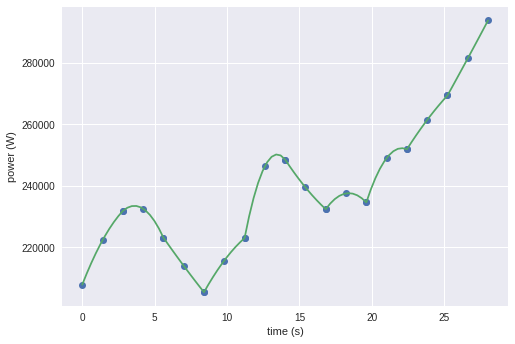

In [19]:
plt.figure()
plt.plot(sol.get_val('traj.phase0.timeseries.time'), sol.get_val('traj.phase0.timeseries.controls:power'), 'o')
plt.plot(sim.get_val('traj.phase0.timeseries.time'), sim.get_val('traj.phase0.timeseries.controls:power'), '-')
plt.xlabel('time (s)')
plt.ylabel('power (W)')

Text(0, 0.5, '$\\theta$ (rad)')

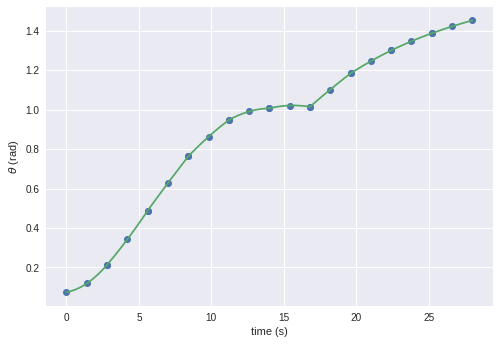

In [20]:
plt.figure()
plt.plot(sol.get_val('traj.phase0.timeseries.time'), sol.get_val('traj.phase0.timeseries.controls:theta'), 'o')
plt.plot(sim.get_val('traj.phase0.timeseries.time'), sim.get_val('traj.phase0.timeseries.controls:theta'), '-')
plt.xlabel('time (s)')
plt.ylabel(r'$\theta$ (rad)')

Text(0, 0.5, 'y (m)')

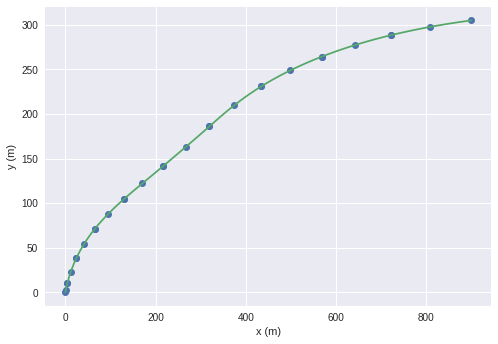

In [21]:
plt.figure()
plt.plot(sol.get_val('traj.phase0.timeseries.states:x'), sol.get_val('traj.phase0.timeseries.states:y'), 'o')
plt.plot(sim.get_val('traj.phase0.timeseries.states:x'), sim.get_val('traj.phase0.timeseries.states:y'), '-')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

Text(0, 0.5, "acceleration (g's)")

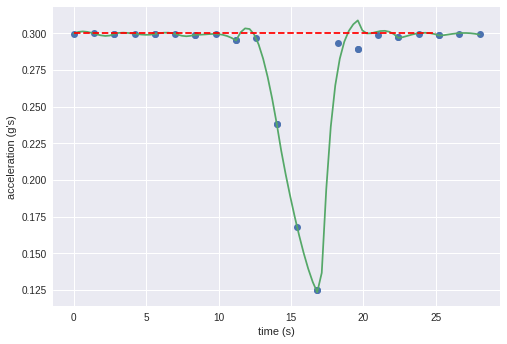

In [22]:
plt.figure()
plt.plot(sol.get_val('traj.phase0.timeseries.time'), sol.get_val('traj.phase0.timeseries.acc'), 'o')
plt.plot(sim.get_val('traj.phase0.timeseries.time'), sim.get_val('traj.phase0.timeseries.acc'), '-')
plt.plot([0, 25], [0.3, 0.3], 'r--')
plt.xlabel('time (s)')
plt.ylabel('acceleration (g\'s)')

Text(0, 0.5, 'angle-of-attack (rad)')

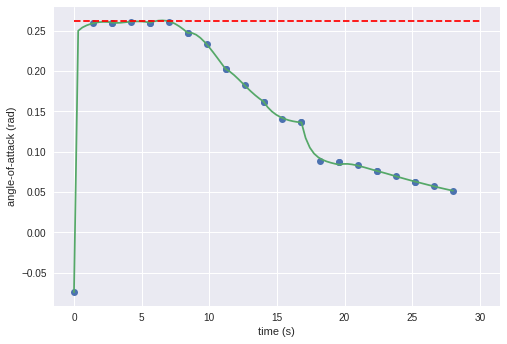

In [23]:
plt.figure()
plt.plot(sol.get_val('traj.phase0.timeseries.time'), sol.get_val('traj.phase0.timeseries.aoa'), 'o')
plt.plot(sim.get_val('traj.phase0.timeseries.time'), sim.get_val('traj.phase0.timeseries.aoa'), '-')
plt.plot([0, 30], np.radians([15, 15]), 'r--')
plt.xlabel('time (s)')
plt.ylabel('angle-of-attack (rad)')

Text(0, 0.5, 'thrust (N)')

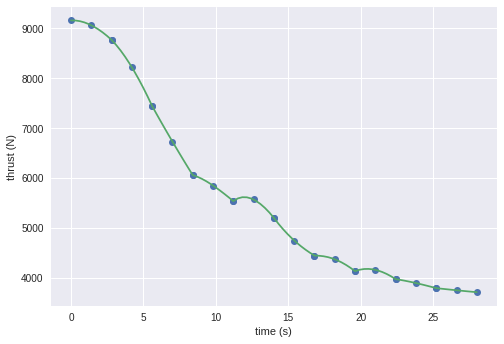

In [24]:
plt.figure()
plt.plot(sol.get_val('traj.phase0.timeseries.time'), sol.get_val('traj.phase0.timeseries.thrust'), 'o')
plt.plot(sim.get_val('traj.phase0.timeseries.time'), sim.get_val('traj.phase0.timeseries.thrust'), '-')
plt.xlabel('time (s)')
plt.ylabel('thrust (N)')

These plots match the original implementation fairly well, but provide a slightly better solution (6.7E7 J vs 6.74E7 J).

The dymos solution respects the acceleration limit (0.3 g's) much more tightly than the original implementation.  The original K-S function-based path constraints are inherently conservative, and it's possible that dymos is buying a small amount of performance by more closely riding the limit.
